# Written by Cody Kesler for BYU 401R Project
# Proprietary data and use for Proctor and Gamble

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import re
import numpy as np
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [16.0,8.0]
import os
import datetime as dt
from time import time
import pickle

In [2]:
def clean_dataset(name, load=True):
    """
    params:
        name: string, name of line. Ex: AA11
        load: Bool, Flag to create a new pickle file or not
        
    returns:
        ds: DataFrame, Data loaded and cleaned
    """
    file_name = name + " Metering Roll Data.txt"
    
    clean_ds_pkl = name + "_clean.pkl"
    
    # clean the dataset
    if load and os.path.exists(clean_ds_pkl):
        return pd.read_pickle(clean_ds_pkl)
        
    if name in ['CG63']:
        ds = pd.read_csv(file_name, sep=',')
    else:
        ds = pd.read_csv(file_name, sep='\t',encoding='utf-16')

    ds.drop(['Feature','Function 1', 
             'Function 2','Value_String', 
             'Quality','Process'], axis=1, inplace=True)

    ds.Value_Double = ds.Value_Double.astype('float')
    ds = ds.dropna()

    # redefine time stamp to UNIX
    ds['time'] = pd.to_datetime(ds['Date Time'].values).astype(int)/ 10**9
    ds.drop('Date Time',axis=1,inplace=True)

    ds.to_pickle(clean_ds_pkl)

    return ds

In [3]:
def get_line_speed(name, ds, load=True):
    """
    params:
         name: string, name of line. Ex: AA_11
         ds: DataFrame, from clean_dataset()
         load: Bool, Flag to create a new pickle file or not
        
    returns:
        ls DataFrame: Has lines speeds from the dataset
    """   
    
    line_speed_pkl = name + "_line_speed.pkl"
    
    if load and os.path.exists(line_speed_pkl):
        return pd.read_pickle(line_speed_pkl)
        
    # get the line speed rows
    ls = ds[ds['Tag Name'].str.contains('Line.Speed')]

    # reformat columns
    ls.rename(inplace=True,columns={"Value_Double":'line_speed'})


    # drop columns
    ls.drop(['Tag Name'],axis=1,inplace=True)
    
    # get line speed diff and time diff
    ls['dif'] = np.append(abs(ls.line_speed.values[1:] - ls.line_speed.values[:-1]),0)
    ls['time_dif'] = np.append(abs(ls['time'].values[1:] - ls['time'].values[:-1]),0)
    ls.iloc[:-1,2] = ls.index.values[1:] - ls.index.values[:-1]

    ls.to_pickle(line_speed_pkl)

    return ls

In [4]:
def get_start_end_range(name, ls, 
                        before=1, after=9, 
                        up_time_tol=10, 
                        label_tol=1.5, up_speed=905,
                        load= True):
    """
     params:
         name: string, name of line. Ex: AA_11
         ls: DataFrame, Linespeed data from get_line_speed()
         before: Int, Minutes to look at before ramp up time
         after: Int, Minutes to look at after ramp up
         up_time_tol: Int, Minutes of uptime to look at 
         label_tol: Float, Hours of uptime to consider the run 'good'
         up_speed: Int, Speed of motor at ramp up time
         load: Bool, Flag to create a new pickle file or not
        
    returns:
        up_time DataFrame: Has lines speeds filtered by given params 
    """
    
    up_time_pkl = name + "_up_time.pkl"
    
    if load and os.path.exists(up_time_pkl):
        return pd.read_pickle(up_time_pkl)
        
    # filter out longer than up_time_tol min differences and up times
    m1 = ls.time_dif>=60*up_time_tol
    m2 = ls.line_speed >= up_speed

    # get up start times
    up_time = ls[m1*m2].copy()

    # convert to hours
    up_time.time_dif = up_time.time_dif/60/60

    # get labels for greater than 
    up_time['label'] = up_time.time_dif > label_tol

    # 1 minute before
    up_time['start'] = (up_time['time']-(60*before))

    # 9 min after steady state
    up_time['end'] = (up_time['time']+(60*after))
    
    up_time = up_time.reset_index().drop('index',axis=1)
    
    up_time.to_pickle(up_time_pkl)

    return up_time

In [5]:
def get_features_measurements(ds):
    """
    params:
        ds: DataFrame, from clean_dataset()
        
    returns:
        features: Dict[feature] = [measurment]
    """
    # define regex to get the features and traits of each feature
    tag_filter = re.compile(r"\bf_([A-Z]*\..*)M")
    measure_filter = re.compile(r".([a-zA-Z]*.[a-zA-Z]*)$")

    tags = ds[['Tag Name']].drop_duplicates().values

    features = {}
    measure = []
    for tag in tags: 
        f = tag_filter.findall(tag[0])
        t = measure_filter.findall(tag[0])
        if len(f) == 1:
            f = f[0]
            if f in features:
                if len(t) == 1:
                    features[f].append(t[0])
            else:
                if len(t) == 1:
                    features[f] = t 
                    
    return features

In [6]:
def extract_data(name, 
                 ds, time_df, features, 
                 before=1, after=9, 
                 load=False):
    """
    params:
        name: string, name of line. Ex: AA11
        ds: DataFrame, from clean_dataset()
        time_df: DataFrame, from get_start_end_range()
        before: Int, Minutes to look at before ramp up time
        after: Int, Minutes to look at after ramp up
        
        load: Bool, Flag to create a new pickle file or not
        
    This function pulls the data for servos measurments 
    within the given time in time_df
    
    """
    
    data_pkl = name + "_full_data.pkl"
    
    if load and os.path.exists(data_pkl):
        return pd.read_pickle(data_pkl)


    # create matrix to store data 
    num_features = len(features)
    num_pnts = before+after
    num_measure = len(list(features.values())[0])-1
    n = num_features*num_pnts*num_measure

    X = np.zeros((len(time_df), n))

    # for each 'data point' (start and end time row)
    columns = []
    for (i,(s,e)) in enumerate(zip(time_df.start,time_df.end)):
        # mask out data in time range
        m1 = s <= ds.time
        m2 = ds.time <= e
        valid_df = ds[m1*m2]

        data = []
        # loop through the features
        for f in features:
            # mask for the feature
            feature_mask = valid_df['Tag Name'].str.contains(f).values

            # loop through the measurments of the feature
            for m in features[f]:
                # mask out the feature and measurement
                measure_mask = valid_df['Tag Name'].str.contains(m).values

                pnts = list(valid_df[feature_mask*measure_mask].Value_Double.values)

                # add or remove elements to get them to length before + after
                if len(pnts) < num_pnts:
                    # fill with mean on right side
                    pnts = list(np.pad(pnts,(0,(num_pnts-len(pnts))),mode='mean'))
                else:
                    pnts = pnts[:num_pnts]

                # create the column names
                if i == 0 and m != "Velocity.Command":
                    columns = columns + [f[:-1]+"_"+m[:-7]+str(k) for k in range(num_pnts)]

                data = data + pnts


            # adjust the columns
            data[-20:-10] = abs(np.array(data[-20:-10]) - np.array(data[-10:]))
            data = data[:-10]
            
            
        # stick in data matrix
        X[i,:] = data

    # make data frame
    data_df = pd.DataFrame(X,columns=columns)
    
    # make full data
    full_data = time_df.merge(data_df,left_index=True, right_index=True)
    
    # remove any crazy outliers
    full_data = full_data[full_data.time_dif > 400]

    full_data.to_pickle(data_pkl)

    return full_data

In [61]:
def get_line_data(name, 
                before=1, after=9, 
                up_time_tol=10, label_tol=1.5,
                load=True, prnt_time=False):
    """
        name: string, name of line. Ex: AA_11
        before: Int, Minutes to look at before ramp up time
        after: Int, Minutes to look at after ramp up
        up_time_tol: Int, Minutes of uptime to look at 
        label_tol: Float, Hours of uptime to consider the run 'good'
        load: Bool, Flag to create a new pickle file or not
         
        This function takes a dataset and returns data points 
        for predicting uptime longer than label_tol
    """
    name = "./" + name
    
    pkl_name = name + "_"+ str(label_tol) +"_full_data.pkl"
    
    if load and os.path.exists(pkl_name):
        return pd.read_pickle(pkl_name)
    
    # clean the dataset
    start_time = time()
    if prnt_time: print("Cleaning Dataset...")
    ds = clean_dataset(name)
    if prnt_time: print("Done:", time()-start_time, '\n')
        
    # extract the line speed from dataset
    start_time = time()
    if prnt_time: print("Extracting Line Speeds...")
    ls = get_line_speed(name, ds)
    if prnt_time: print("Done:", time()-start_time, '\n')
        
    # get the -1 min to +9 min after ramp up time
    start_time = time()
    if prnt_time: print("Extracting Time Ranges and Labels...")
    time_df = get_start_end_range(name,ls,before,after,up_time_tol,label_tol)
    if prnt_time: print("Done:", time()-start_time, '\n')
    
    # get all the features and corrisponding measurements
    start_time = time()
    if prnt_time: print("Extracting Features and Measurments from data...")
    features = get_features_measurements(ds)
    if prnt_time: print("Done:", time()-start_time, '\n')
    
    # get the data
    start_time = time()
    if prnt_time: print("Making full dataset...")
    full_data = extract_data(name, ds, time_df, features, before, after, load)
    if prnt_time: print("Done:", time()-start_time, '\n')
    
    return full_data

In [62]:
def pandas_dataset(lines,load=False):
    """
        This gets dataset in pandas format for network input
    """
    
    if load and os.path.exists("data_df.pkl"):
        return pd.from_pickle("data_df.pkl")
        
    data = get_line_data(lines[0],True)
    data['line'] = 1
    data.drop(columns=["time","line_speed","dif","time_dif","start","end"],inplace=True)
    
    for i, line in enumerate(lines[1:]):
        df = get_line_data(line,True)
        df['line'] = i+2
        df.drop(columns=["time","line_speed","dif","time_dif","start","end"],inplace=True)
        data = pd.concat([data,df])
        
    data.dropna(inplace=True)
    data.to_pickle("data_df.pkl")
    return data

In [63]:
def make_dataset(lines,load=False):
    """
        This function formats the data into network input format
        
        returns:
        lables: nd.array(nx1)
        data: nd.array(nxfeatures(441))
    """
    
    num_filter = re.compile(r"_([0-9])*$")
    num = num_filter.findall(lines[0])
    if len(num) > 0:
        num = num[0]
    
    data = []
    labels = []
    
    if load and os.path.exists("data.pkl"):
        return pickle.load(open("./data.pkl", "rb" ))
    
    for i, line in enumerate(lines):
        df = get_line_data(line,True)
        df['line'] = i+1
        df.dropna(inplace=True)
        data = data + list(df.iloc[:,7:].values)
        labels = labels + list(df.label.values)
        df.drop(columns=["time","line_speed","dif","time_dif","start","end","label"],inplace=True)
        
    data = np.vstack(data)
    labels = np.array(labels).astype(int)
    pickle.dump(labels, open("./labels_"+num+".pkl", "wb" ))
    pickle.dump(data, open("./data_"+num+".pkl", "wb" ))
    
    return labels, data

In [66]:
def new_label(lines,label_tol):
    """
        Puts a new label on the data for each line in lines
        Creates name_(label_tol)_full_data.pkl file
    """
    
    for line in lines:
        file_name = "./" + line + "/" + line + "_full_data.pkl"
        
        df = pd.read_pickle(file_name)
        df['label'] = df.time_dif > label_tol
        
        save_name = "./" + line + "/" + line + "_" +str(label_tol)+"_full_data.pkl"
        df.to_pickle(save_name)
        
    return

## This is the data formated for use with deep learning, extracted from the data below

In [47]:
#lines to load in 
lines = ['CG67','CG63','AK72','AK74','EUS36','EUS37']

In [48]:
# this is in matrix, vector format
labels, data = make_dataset(lines,False)

In [49]:
# this is in pandas format
data_df = pandas_dataset(lines,False)
data_df

,label,ALM.NWDL_EncoderTemp0,ALM.NWDL_EncoderTemp1,ALM.NWDL_EncoderTemp2,ALM.NWDL_EncoderTemp3,ALM.NWDL_EncoderTemp4,ALM.NWDL_EncoderTemp5,ALM.NWDL_EncoderTemp6,ALM.NWDL_EncoderTemp7,ALM.NWDL_EncoderTemp8,...,TU_Velocity1,TU_Velocity2,TU_Velocity3,TU_Velocity4,TU_Velocity5,TU_Velocity6,TU_Velocity7,TU_Velocity8,TU_Velocity9,line
0,False,42.0,41.0,41.0,41.000000,41.000000,41.000000,41.300000,42.000000,42.000000,...,3.054,1.825,3.279000,3.505000,1.300000,0.727000,1.553000,1.103000,2.126000,1
1,False,44.0,42.0,42.0,42.000000,42.000000,42.000000,44.000000,44.000000,44.000000,...,4.228,4.453,0.098000,2.726000,5.129000,8.084000,5.382000,1.778000,2.051000,1
2,True,44.0,42.0,42.0,42.000000,42.000000,43.300000,43.300000,44.000000,44.000000,...,2.051,1.403,0.802000,1.553000,0.849000,3.852000,3.204000,1.900000,0.024000,1
3,True,47.0,47.0,46.0,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,...,0.774,4.378,2.276000,0.024000,0.352000,6.480000,0.474000,0.474000,2.651000,1
4,True,41.0,41.0,41.0,41.000000,41.000000,41.000000,41.000000,41.000000,42.000000,...,1.525,0.051,2.679000,1.403000,2.126000,2.979000,0.999000,2.501000,1.600000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
363,False,54.0,54.0,54.0,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,...,0.474,2.829,0.051000,0.249000,2.276000,2.801000,1.928000,0.549000,0.172822,6
364,False,46.0,45.0,45.0,45.000000,45.000000,45.000000,45.000000,46.000000,45.250000,...,0.474,1.225,1.628000,1.975000,3.852000,2.078000,2.004000,2.004000,0.549000,6
365,False,44.0,44.0,44.0,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,...,6.583,1.075,3.627000,2.200000,1.177000,4.631000,7.033000,5.729000,1.300000,6
366,True,47.0,46.0,46.0,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,...,1.177,1.853,1.028000,0.174000,1.778000,2.004000,3.777000,0.999000,1.028000,6


## This is the data for The CG 67 line
   The labels are for longer uptime than 1.5 hours and the data is the servos motors of the first 10 minutes of run time

In [65]:
CG_67_data = get_line_data("CG67",True)
CG_67_data

,time,line_speed,dif,time_dif,label,start,end,ALM.NWDL_EncoderTemp0,ALM.NWDL_EncoderTemp1,ALM.NWDL_EncoderTemp2,...,TU_Velocity0,TU_Velocity1,TU_Velocity2,TU_Velocity3,TU_Velocity4,TU_Velocity5,TU_Velocity6,TU_Velocity7,TU_Velocity8,TU_Velocity9
0,1.567956e+09,910.0,1.0,0.211111,False,1.567956e+09,1.567957e+09,42.0,41.0,41.0,...,0.0000,3.054,1.825,3.279,3.505,1.300,0.727,1.553,1.103,2.126
1,1.567960e+09,910.0,1.0,0.201667,False,1.567960e+09,1.567960e+09,44.0,42.0,42.0,...,0.0144,4.228,4.453,0.098,2.726,5.129,8.084,5.382,1.778,2.051
2,1.567961e+09,910.0,1.0,1.550000,True,1.567961e+09,1.567962e+09,44.0,42.0,42.0,...,0.0000,2.051,1.403,0.802,1.553,0.849,3.852,3.204,1.900,0.024
3,1.567969e+09,910.0,1.0,1.975833,True,1.567969e+09,1.567969e+09,47.0,47.0,46.0,...,1.7122,0.774,4.378,2.276,0.024,0.352,6.480,0.474,0.474,2.651
4,1.567978e+09,910.0,1.0,1.999167,True,1.567978e+09,1.567979e+09,41.0,41.0,41.0,...,0.0606,1.525,0.051,2.679,1.403,2.126,2.979,0.999,2.501,1.600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
436,1.570382e+09,910.0,1.0,1.037222,False,1.570382e+09,1.570383e+09,54.0,54.0,54.0,...,1.4408,1.600,0.549,1.300,0.174,3.580,3.955,1.825,0.699,0.249
437,1.570387e+09,910.0,1.0,0.223889,False,1.570387e+09,1.570388e+09,51.0,50.0,50.0,...,0.4360,1.825,1.028,1.450,1.628,2.303,1.928,0.802,2.051,2.754
438,1.570388e+09,910.0,1.0,0.347222,False,1.570388e+09,1.570389e+09,49.0,49.0,49.0,...,19.9580,2.126,2.876,1.300,1.103,2.078,1.553,0.999,1.975,0.727
439,1.570390e+09,910.0,1.0,1.128889,False,1.570390e+09,1.570390e+09,50.0,49.0,49.0,...,9.5616,1.403,2.529,2.454,0.877,0.174,1.075,1.177,1.628,2.351


## This the the histogram of the uptimes for CG 67

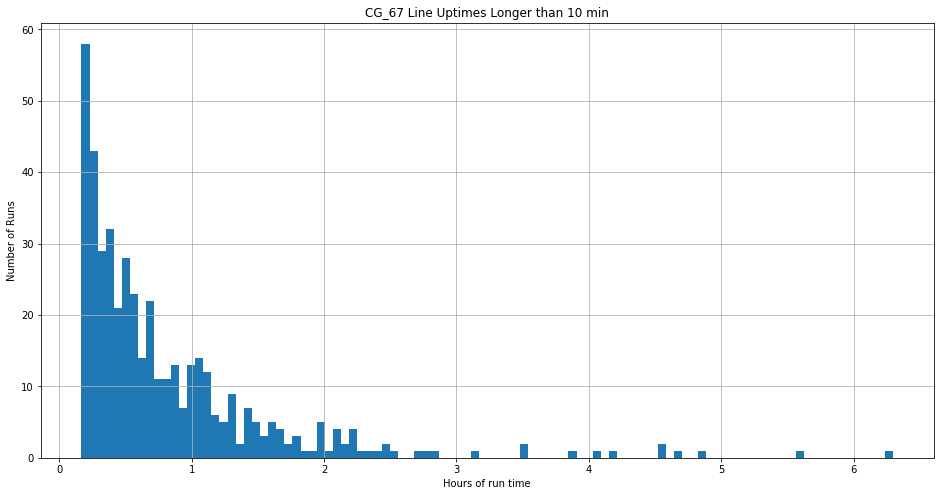

In [71]:
CG_67_data.time_dif.hist(bins=100)
plt.title("CG67 Line Uptimes Longer than 10 min")
plt.xlabel('Hours of run time')
plt.ylabel("Number of Runs")
plt.show()

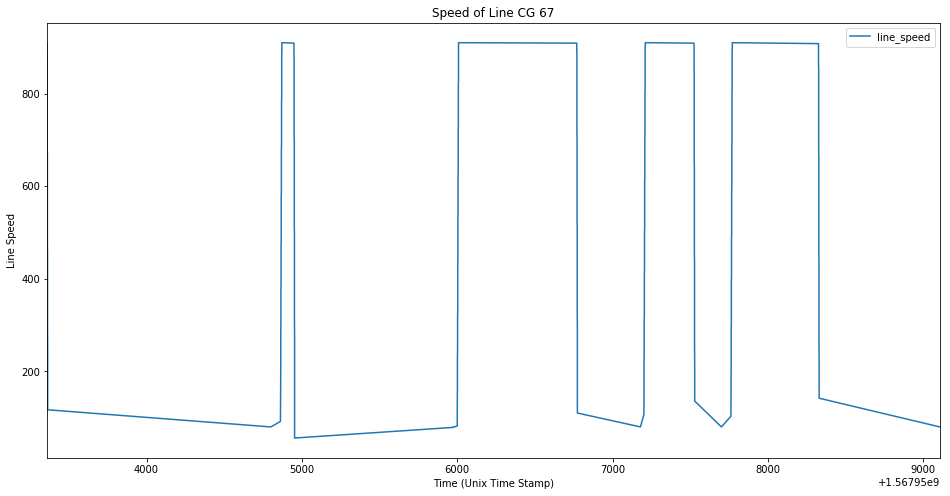

In [190]:
# sample of ramping up and ramping down
ls = get_line_speed('CG67', "",load=True)
ls.head(500).plot(y='line_speed')
plt.title("Speed of Line CG 67")
plt.xlabel("Time (Unix Time Stamp)")
plt.ylabel("Line Speed")
plt.show()

In [5]:
ds = clean_dataset("CG67",load=True)

In [6]:
ds.sample(10)

,Tag Name,Value_Double,time
6583756,f_CUU.Meter.Omega.Axis.PositionError.Actual,-0.024774,1.568684e+09
3069370,f_ALU.Meter.Omega.Axis.Velocity.Actual,4940.984000,1.568679e+09
1640990,f_ALU.Meter.Omega.Axis.Torque.Actual,13.000000,1.568362e+09
6482663,f_CUU.Meter.Omega.Axis.PositionError.Actual,0.000000,1.568126e+09
6670218,f_CUU.Meter.Omega.Axis.PositionError.Actual,0.024023,1.569154e+09
11138718,Line.State,1.000000,1.568584e+09
10136760,f_TU.Meter.Omega.Axis.Velocity.Actual,7513.575000,1.568057e+09
1092438,f_ALU.Meter.Omega.Axis.PositionError.Actual,-0.000751,1.569655e+09
9883174,f_TU.Meter.Omega.Axis.Torque.Actual,12.600000,1.568633e+09
1727912,f_ALU.Meter.Omega.Axis.Torque.Actual,9.700000,1.568530e+09
